F:/seismic/models/brendan/*.pth
Loading:  F:/seismic/models/brendan\unet2d_caformer_seed3_epochbest.pt
1
n_models: 1


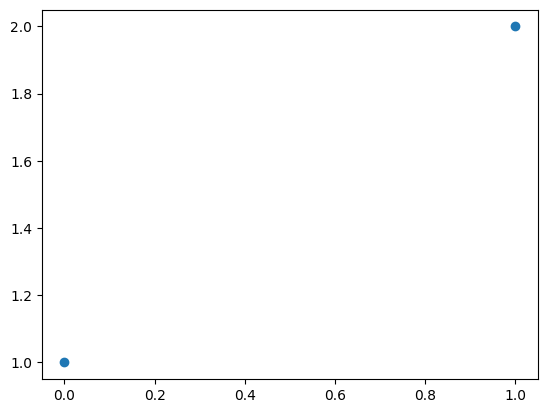

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward
import seis_test
import seis_invert
import seis_prior
import seis_nn
import cupy as cp
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

10000
FlatVel_B


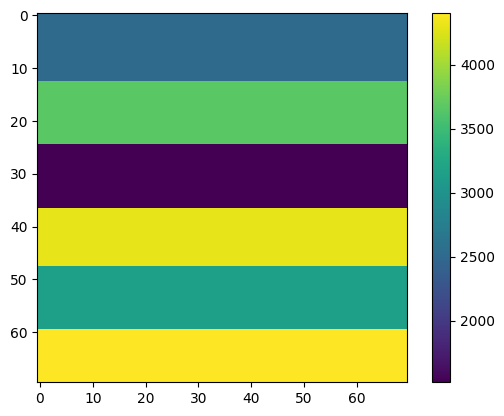

In [2]:
importlib.reload(kgs)
data=kgs.load_all_train_data()
print(len(data))
for d in data:
    d.check_constraints()
d = data[7011]
print(d.family)
d.load_to_memory()
plt.figure()
plt.imshow(cp.asnumpy(d.velocity.data));plt.colorbar();#plt.clim([-3,3])

In [3]:
# TODO: tune lambda, tune convergence criteria, tune L vs full, velB
seis_correct = seis_forward.vel_to_seis(d.velocity, d.seismogram)[0]
d_guess = seis_nn.default_pretrained.infer([d])[0]
d_guess.velocity_guess.data = cp.array(d_guess.velocity_guess.data)
d_guess.velocity_guess.min_vel = cp.array(d_guess.velocity_guess.min_vel)
# offset_vector = cp.array(1e1*np.random.default_rng(seed=0).normal(0,1,size=d.velocity.to_vector().shape), dtype=kgs.base_type_gpu)
# velocity_offset = copy.deepcopy(d.velocity)
# velocity_offset.from_vector(velocity_offset.to_vector() + offset_vector)
# prior = seis_prior.RowTotalVariation(λ=1e-20)
# basis_functions = prior.basis_functions()
#print(seis_invert.cost_and_gradient(cp.linalg.solve(basis_functions.T@basis_functions, basis_functions.T@(d.velocity.to_vector())), seis_correct.to_vector(), prior, basis_functions))
#print(seis_invert.cost_and_gradient(cp.linalg.solve(basis_functions.T@basis_functions, basis_functions.T@(velocity_offset.to_vector())), seis_correct.to_vector(), prior, basis_functions))
#print('base RMS', kgs.rms(cp.asnumpy(cp.mean(velocity_offset.data - d.velocity.data,axis=0)[:,None] + 0*d.velocity.data)))
#print('base seis diff', kgs.rms(cp.asnumpy(seis_correct.to_vector() - seis_forward.vel_to_seis(velocity_offset, seis_correct)[0].to_vector())))

In [4]:
importlib.reload(seis_invert)
λ_vals = 10**np.linspace(-11,-6,6)
#λ_vals = [10**-9]
maxiter=2000
res = [[],[],[]]
rms_vals = [[],[],[]]
cost_vals = [[],[],[]]
res_vals = [[],[],[]]

In [5]:
NN=3
for λ in λ_vals:    
    prior = seis_prior.RowTotalVariation()
    prior.λ=λ
    prior.epsilon = 0.1
    basis_functions = prior.basis_functions()
    #seis_invert.true_vel = d.velocity
    res[0].append(seis_invert.seis_to_vel(seis_correct, d.velocity, prior, maxiter=maxiter)[0])
    print('done1', λ)
    res[1].append(seis_invert.seis_to_vel(d.seismogram, d.velocity, prior,maxiter=maxiter)[0])
    print('done2', λ)
    res[2].append(seis_invert.seis_to_vel(d.seismogram, d_guess.velocity_guess, prior,maxiter=maxiter)[0])
    print('done2', λ)
    for ii in range(NN):
        rms_vals[ii].append(cp.asnumpy(kgs.rms(res[ii][-1].to_vector()-d.velocity.to_vector())))
        cost_vals[ii].append( cp.asnumpy(
            seis_invert.cost_and_gradient(cp.linalg.solve(basis_functions.T@basis_functions, basis_functions.T@(res[ii][-1].to_vector())), seis_correct.to_vector(), prior, basis_functions)[0] ))
        res_vals[ii].append(cp.asnumpy(kgs.rms( kgs.rms( seis_correct.data - seis_forward.vel_to_seis(res[ii][-1], d.seismogram)[0].data ) )))
    print('RMS', λ, rms_vals[0], rms_vals[1], rms_vals[2])
    print('Cost', λ, cost_vals[0], cost_vals[1], cost_vals[2])
    print('res', λ, res_vals[0], res_vals[1], res_vals[2])

int 1.727532827715552
capturing graph
capturing graph
done1 1e-11
int 1.7275347882642003
done2 1e-11
int 1.7275347882642003
done2 1e-11
RMS 1e-11 [array(0.0283151)] [array(0.22279913)] [array(0.22281458)]
Cost 1e-11 [array(1.22973583e-09)] [array(1.38597341e-09)] [array(1.38597259e-09)]
res 1e-11 [array(5.62487454e-08)] [array(1.2478693e-05)] [array(1.24786596e-05)]
int 1.727532827715552
done1 1e-10
int 1.7275347882642003
done2 1e-10
int 1.7275347882642003
done2 1e-10
RMS 1e-10 [array(0.0283151), array(0.03380975)] [array(0.22279913), array(0.07703398)] [array(0.22281458), array(0.07705096)]
Cost 1e-10 [array(1.22973583e-09), array(1.22972659e-08)] [array(1.38597341e-09), array(1.24520687e-08)] [array(1.38597259e-09), array(1.24520654e-08)]
res 1e-10 [array(5.62487454e-08), array(2.44802999e-07)] [array(1.2478693e-05), array(1.24158307e-05)] [array(1.24786596e-05), array(1.24156996e-05)]
int 1.727532827715552
done1 1e-09
int 1.7275347882642003
done2 1e-09
int 1.7275347882642003
done2 1

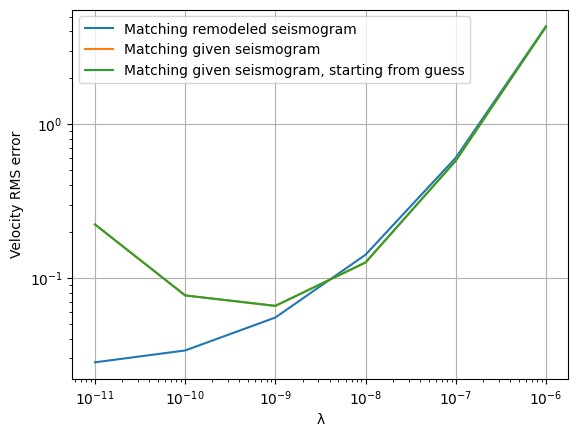

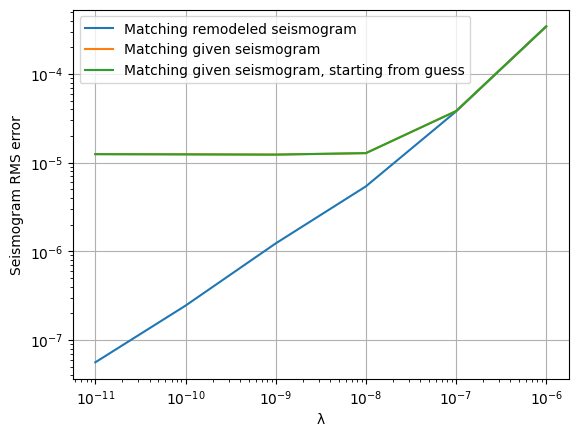

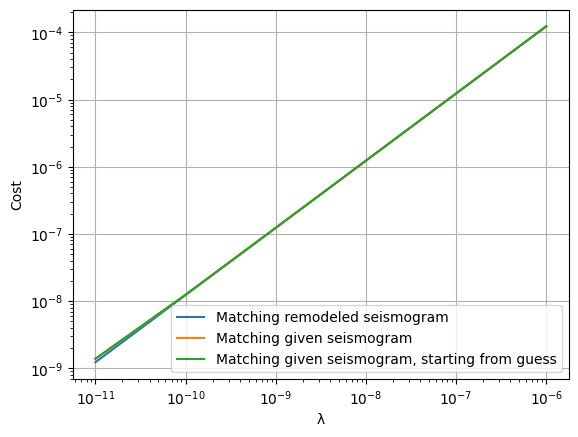

In [6]:
for to_plot in [[rms_vals, 'Velocity RMS error'], [res_vals, 'Seismogram RMS error'], [cost_vals, 'Cost']]:
    plt.figure()
    plt.loglog(λ_vals, to_plot[0][0])
    plt.loglog(λ_vals, to_plot[0][1])
    plt.loglog(λ_vals, to_plot[0][2])
    plt.xlabel('λ')
    plt.ylabel(to_plot[1])
    plt.grid(True)
    plt.legend(('Matching remodeled seismogram', 'Matching given seismogram', 'Matching given seismogram, starting from guess'))

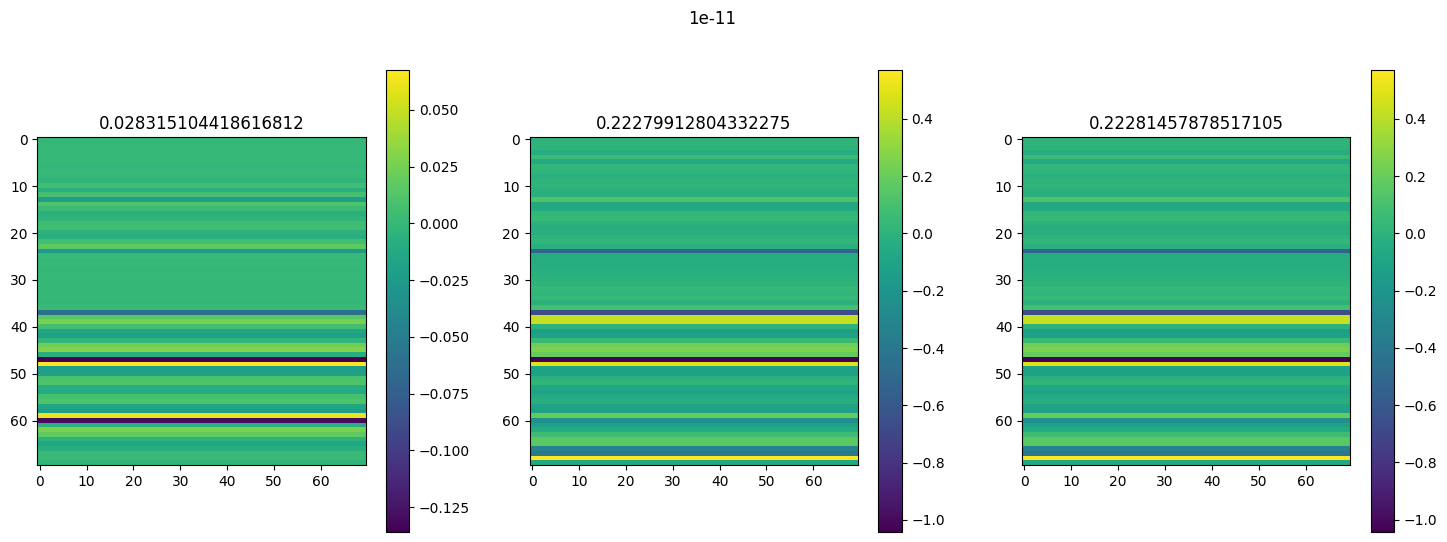

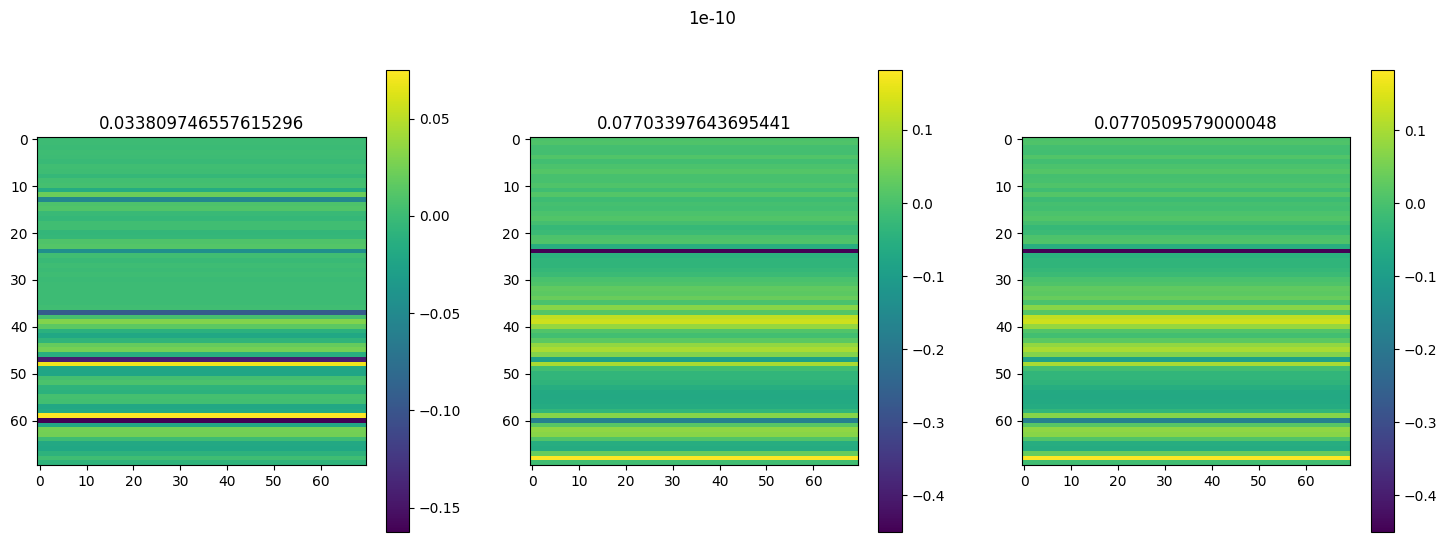

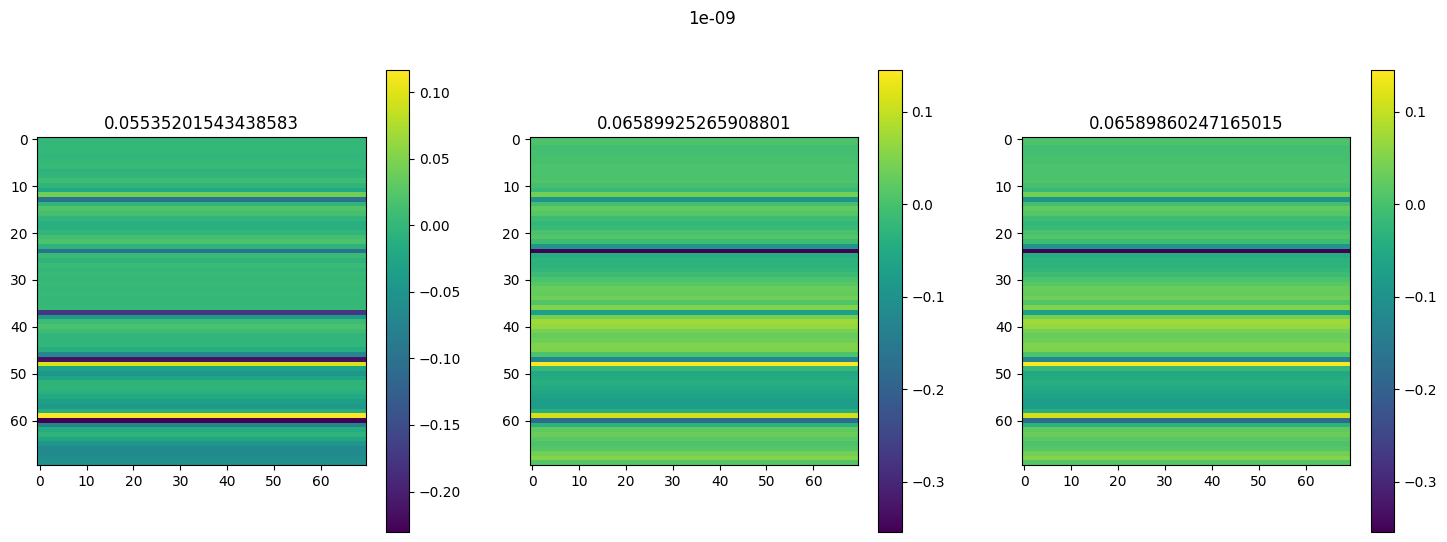

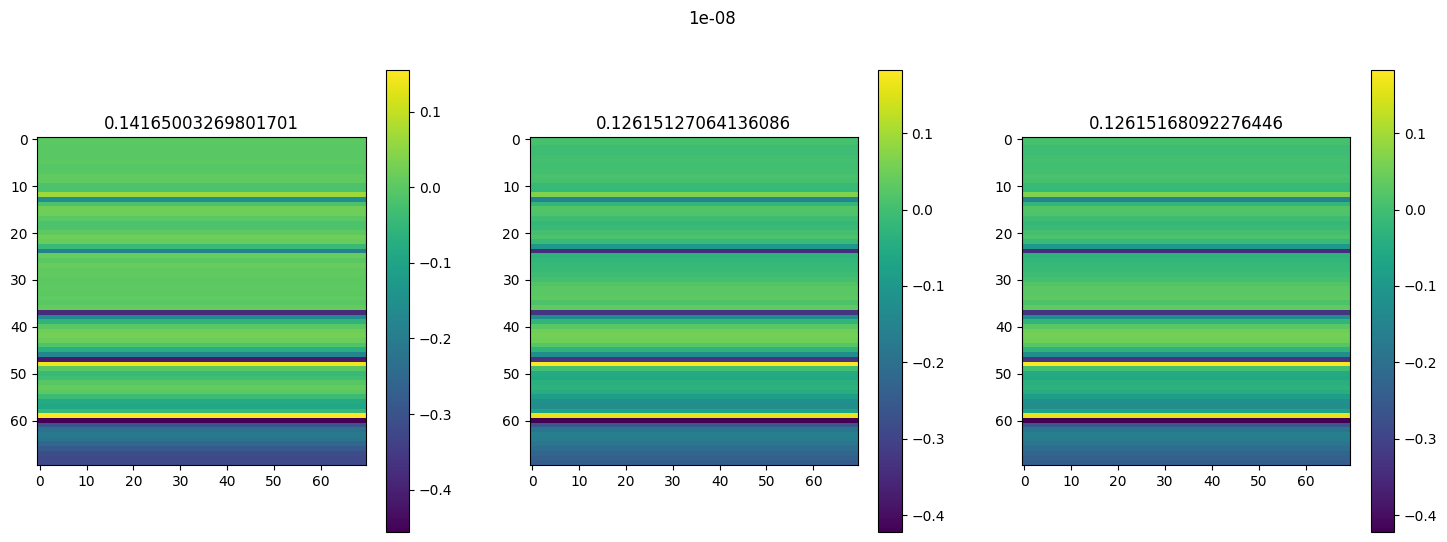

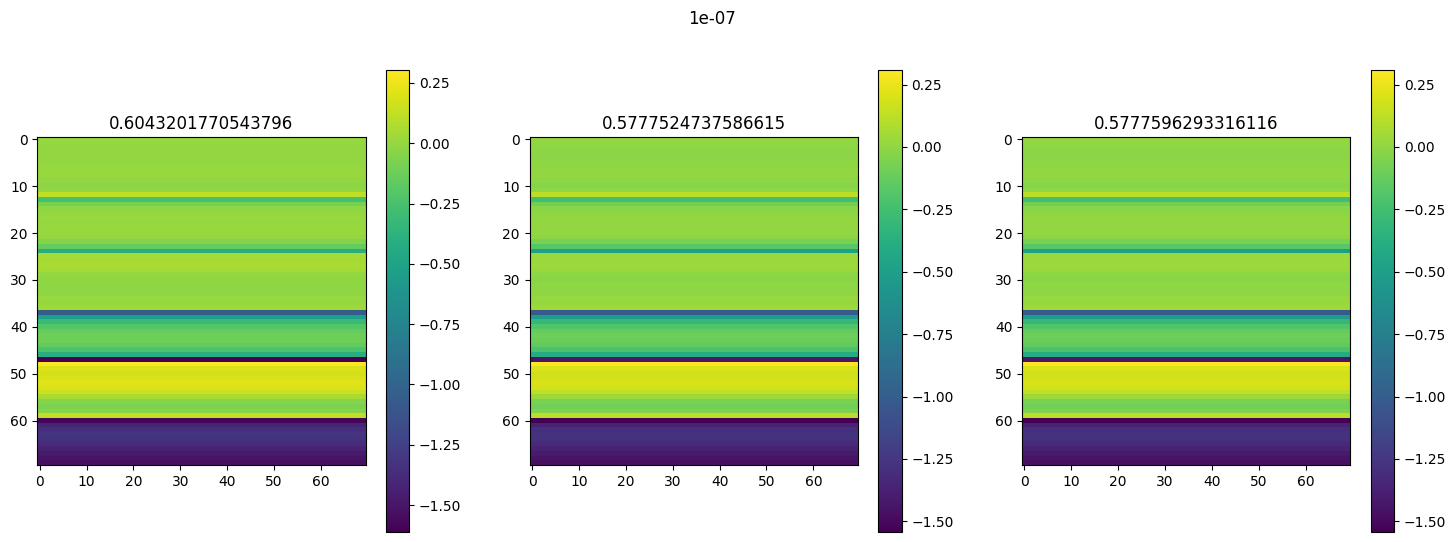

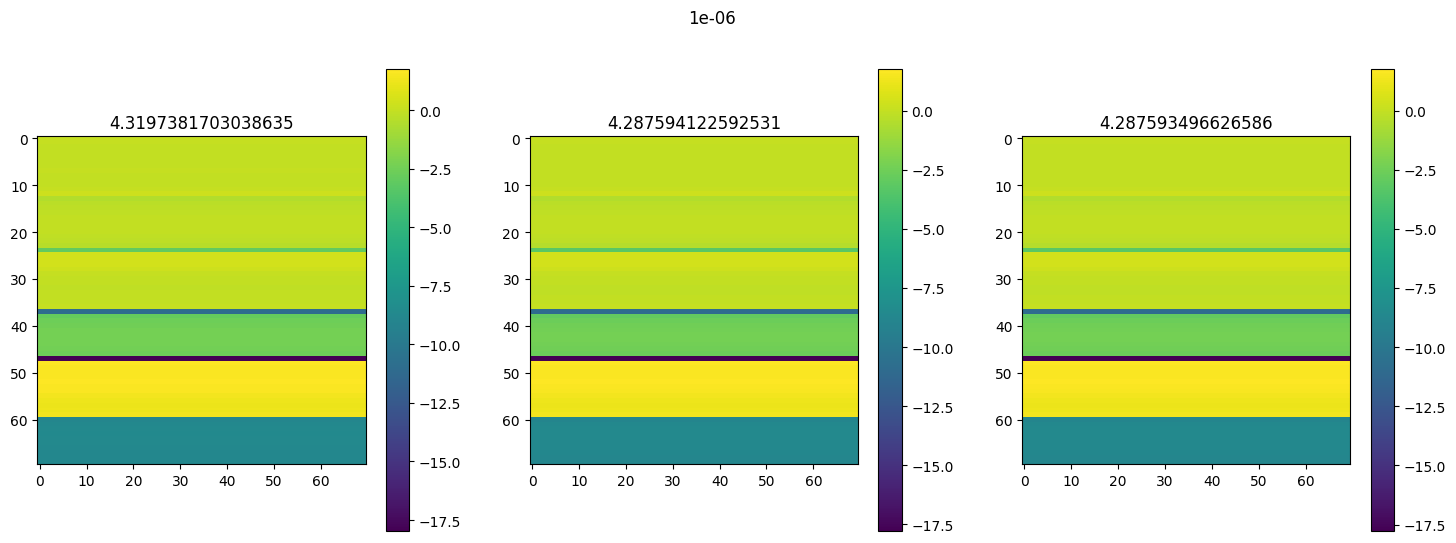

In [7]:
#plt.figure()
#plt.imshow( cp.asnumpy(velocity_offset.data - d.velocity.data));plt.colorbar()
#plt.figure()
#plt.imshow( cp.asnumpy(cp.mean(velocity_offset.data - d.velocity.data,axis=0)[:,None] + 0*d.velocity.data));plt.colorbar()
#plt.title(kgs.rms (cp.mean(velocity_offset.data - d.velocity.data,axis=0)[:,None] + 0*d.velocity.data))
for i,λ in enumerate(λ_vals): 
    _,ax=plt.subplots(1,NN,figsize=(6*NN,6))
    for ii in range(NN):
        plt.sca(ax[ii])
        plt.imshow( cp.asnumpy(res[ii][i].data - d.velocity.data));plt.colorbar()
        plt.title(rms_vals[ii][i])
    plt.suptitle(λ)

In [8]:
rms_vals

[[array(0.0283151),
  array(0.03380975),
  array(0.05535202),
  array(0.14165003),
  array(0.60432018),
  array(4.31973817)],
 [array(0.22279913),
  array(0.07703398),
  array(0.06589925),
  array(0.12615127),
  array(0.57775247),
  array(4.28759412)],
 [array(0.22281458),
  array(0.07705096),
  array(0.0658986),
  array(0.12615168),
  array(0.57775963),
  array(4.2875935)]]

In [9]:
cost_vals

[[array(1.22973583e-09),
  array(1.22972659e-08),
  array(1.22970252e-07),
  array(1.22965607e-06),
  array(1.2295e-05),
  array(0.00012284)],
 [array(1.38597341e-09),
  array(1.24520687e-08),
  array(1.23123037e-07),
  array(1.22980397e-06),
  array(1.22951386e-05),
  array(0.00012284)],
 [array(1.38597259e-09),
  array(1.24520654e-08),
  array(1.23123037e-07),
  array(1.22980397e-06),
  array(1.22951386e-05),
  array(0.00012284)]]

In [10]:
res_vals

[[array(5.62487454e-08),
  array(2.44802999e-07),
  array(1.2307478e-06),
  array(5.40905163e-06),
  array(3.77735804e-05),
  array(0.00034427)],
 [array(1.2478693e-05),
  array(1.24158307e-05),
  array(1.23356896e-05),
  array(1.28125645e-05),
  array(3.81429536e-05),
  array(0.00034317)],
 [array(1.24786596e-05),
  array(1.24156996e-05),
  array(1.23356854e-05),
  array(1.28125561e-05),
  array(3.81431909e-05),
  array(0.00034317)]]

In [11]:
λ_vals = [-13]

In [12]:
NN=2